In [1]:
from notepad import WaterStorage, Heatpump

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import cufflinks
cufflinks.go_offline()

In [3]:
data = pd.read_excel('Demand_Data_Smurfit_Preprocessed.xlsx', sheet_name='nov2018', index_col=0)
start, end = '2018-11-01 00:00:00', '2018-11-01 12:00:00'
df = data[start:end]
df = df.resample('15T', origin=start).mean()
df=df.drop(['Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'], axis=1)
df[:10]

Tsource (VDG)  Tsink (VDG)   MW (VDG)  Tsource (NDG)  \
2018-11-01 00:00:00      64.964783   142.003109   0.000000      19.897433   
2018-11-01 00:15:00      54.578777   138.960493   0.000000      17.950905   
2018-11-01 00:30:00      65.166672   139.885329   0.000000      33.500757   
2018-11-01 00:45:00      65.358078   139.731901   0.000000      42.203876   
2018-11-01 01:00:00      64.947536   139.577871   0.000000      18.702675   
2018-11-01 01:15:00      65.073433   139.423357   0.000000      19.903652   
2018-11-01 01:30:00      47.711559   140.328730   0.000000      19.574467   
2018-11-01 01:45:00      29.525829   140.298902   0.000000      17.065464   
2018-11-01 02:00:00      65.715569   139.991650  10.139587      49.339708   
2018-11-01 02:15:00      65.929909   148.342325  19.585104      61.721718   

                     Tsink (NDG)  MW (NDG)  
2018-11-01 00:00:00   147.731814  0.000000  
2018-11-01 00:15:00   148.138964  0.000000  
2018-11-01 00:30:00   147.585426  0.000000  
2018-11-01 00:45:00   147.547612  0.000000  
2018-11-01 01:00:00   148.260335  0.000000  
2018-11-01 01:15:00   149.186865  0.000000  
2018-11-01 01:30:00   147.800016  0.000000  
2018-11-01 01:45:00   147.906886  0.000000  
2018-11-01 02:00:00   149.603741  3.333301  
2018-11-01 02:15:00   155.887905  6.455359

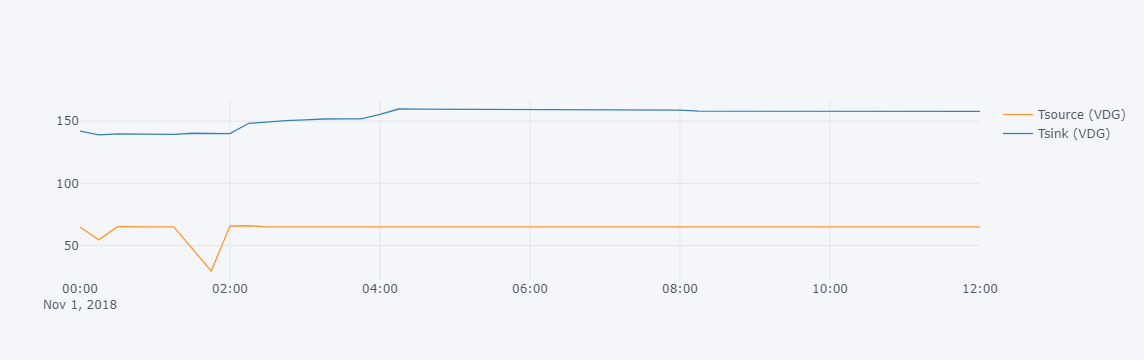

In [43]:
df[['Tsource (VDG)', 'Tsink (VDG)']].iplot()

In [5]:
waterstorage = WaterStorage(
    name='MyStorage',
    max_power=10,
    min_power=-10,
    roundtrip_eff=0.90,
    energy_density = 50 * 1e-3,
    volume = 1000,
    lifetime = 25,
    temperature = 368, #K
    min_storagelevel = 5,
    # max_storagelevel = 50
    
)
waterstorage.set_freq('15T')
waterstorage.set_storagelevel(15)
waterstorage.storagelevel

15

In [6]:
waterstorage.max_storage_capacity

50.0

In [7]:
def hp_mass_flow (hp_capacity, Tsink, Tref, Cp):
    return hp_capacity /(Cp*(Tsink - Tref)) 

def process_mass_flow (demand, Tsink, Tref, Cp):
    return demand /(Cp*(Tsink - Tref)) 

def COP_calculation(Tsink, Tsource):
    return Tsink / (Tsink - Tsource)

from numpy.polynomial import Polynomial

def cop_curve(Tsink, Tsource):
    c0 = Tsink / (Tsink - Tsource)  
    return Polynomial([c0])


In [8]:
# heatpump = Heatpump("heatpump1", 50, cop_curve, 10)
# heatpump.set_heat_output(50, Tsource=333, Tsink=413)
cop_curve(140, 60)

heatpump = Heatpump(
    name='Heatpump',
    max_th_power=40,
    min_th_power=5,
    cop_curve=cop_curve
)

heatpump.__dict__



{'name': 'Heatpump',
 'max_th_power': 40,
 'min_th_power': 5,
 'cop_curve': <function __main__.cop_curve(Tsink, Tsource)>}

In [9]:
heatpump.get_cop(50, Tsource=333, Tsink=413)

5.1625

In [10]:
Tsink = 140  #Celcius
Tsource = 60
Tref = 0
hp_capacity = 31 #MW
demand = 25 #MW
Cp = 4190  #J/kgK
MW_to_J_per_s = 1000_000
hp_capacity *= MW_to_J_per_s
demand *= MW_to_J_per_s
efficiency = 0.9
Tstorage = 95

# charge_mass_flow = hp_mass_flow (hp_capacity, Tsink, Tref, Cp) - process_mass_flow (demand, Tsink, Tref, Cp)
# charged_heat = (charge_mass_flow * Cp * (Tsink - Tref)) / MW_to_J_per_s
# charged_heat
charge_mass_flow = hp_mass_flow (hp_capacity, Tsink, Tref, Cp) - process_mass_flow (demand, Tsink, Tref, Cp)
def charged_heat (charge_mass_flow, Cp, Tsink, Tref):
    return (charge_mass_flow * Cp * (Tsink - Tref)) / MW_to_J_per_s


discharged_heat = charged_heat(charge_mass_flow, Cp, Tsink, Tref) * efficiency  #MW
def discharge_mass_flow (discharged_heat, Cp, Tstorage, Tref):
    return discharged_heat * MW_to_J_per_s /(Cp*(Tstorage - Tref))
# discharge_mass_flow = discharged_heat * MW_to_J_per_s /(Cp*(Tstorage - Tref))
# discharge_mass_flow
# process_mass_flow

def Tsource_calculation(Tstorage, discharge_mass_flow, Tsource, process_mass_flow):
        return (Tstorage * discharge_mass_flow(discharged_heat, Cp, Tstorage, Tref) + Tsource * process_mass_flow)/ (discharge_mass_flow(discharged_heat, Cp, Tstorage, Tref) + process_mass_flow)
            

Tsource_calculation(Tstorage, discharge_mass_flow, Tsource, process_mass_flow (demand, Tsink, Tref, Cp))
discharged_heat


5.400000000000001

In [11]:
def test_heatpump_and_waterstorage_system(Tsink, Tsource, process_demand_MW, e_price):
    """
    1. Follow a certain logic based on given price:
        - If price is low --> Heatpump at full power, and charge the heatbuffer
        - If price is high --> Discharge the heat buffer, and increase Tsource, which will increase COP
    2. Above logic should adhere to a couple of constraints:
        - Storage levels
        - Capacity of the heat pump 
        - Process demand
        - ....
    3. This function should contain: 
        - Heat pump 
        - Water storage
        - Interactions / logic between them
    4. Output of the function:
        - Power of the heatpump (MWe)
        - "New" water storage level
        - (optional) Thermal output of the heatpump
        - (optional) In/outflow from the storage
    """
    
    if e_price < 50:
        hp_load = heatpump.max_th_power
        energy_to_storage = hp_load - process_demand_MW
        waterstorage.charge(energy_to_storage)
        new_cl = waterstorage.storagelevel
    if e_price > 100:
        # Tstorage = 95
        energy_from_storage = discharged_heat
        waterstorage.discharge(energy_from_storage)
        new_cl = waterstorage.storagelevel
        def Tsource_calculation(Tstorage, discharge_mass_flow, Tsource, process_mass_flow):
            return (
                (Tstorage * discharge_mass_flow + Tsource * process_mass_flow)
                / (discharge_mass_flow + process_mass_flow)
            )
        new_Tsource = Tsource_calculation(Tstorage, discharge_mass_flow(discharged_heat, Cp, Tstorage, Tref), Tsource, process_mass_flow (demand, Tsink, Tref, Cp))
        new_COP = COP_calculation (Tsink, new_Tsource)
        hp_load = heatpump.set_heat_output(process_demand_MW, Tsink, Tsource) #bu da hemcinin set load assetin funksiyasidir, 
        #heatpump da overwrite edilib. men evezinde yazdim ki set_heat_output
        #sen gor hansi funksiya sene lazimdir.

    return hp_load, new_cl

In [44]:
# hp_load, new_cl = test_heatpump_and_waterstorage_system(
#     Tsink = 140+273, 
#     Tsource = 60+273, 
#     process_demand_MW = 25, 
#     e_price = 30
# )

# hp_load, new_cl


In [15]:
# waterstorage.get_soc (30, 50)

In [14]:
for i in df.index:
    # df.loc[i, 'MWe'] = test_heatpump_and_waterstorage_system(df.loc[i, 'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273, df.loc[i, 'MW (VDG)'], 130)[0][0]
    df.loc[i, 'new_cl'] = test_heatpump_and_waterstorage_system(df.loc[i, 'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273, df.loc[i, 'MW (VDG)'], 30)[1]


In [34]:
df[:10]

Tsource (VDG)  Tsink (VDG)   MW (VDG)  Tsource (NDG)  \
2018-11-01 00:00:00      64.964783   142.003109   0.000000      19.897433   
2018-11-01 00:15:00      54.578777   138.960493   0.000000      17.950905   
2018-11-01 00:30:00      65.166672   139.885329   0.000000      33.500757   
2018-11-01 00:45:00      65.358078   139.731901   0.000000      42.203876   
2018-11-01 01:00:00      64.947536   139.577871   0.000000      18.702675   
2018-11-01 01:15:00      65.073433   139.423357   0.000000      19.903652   
2018-11-01 01:30:00      47.711559   140.328730   0.000000      19.574467   
2018-11-01 01:45:00      29.525829   140.298902   0.000000      17.065464   
2018-11-01 02:00:00      65.715569   139.991650  10.139587      49.339708   
2018-11-01 02:15:00      65.929909   148.342325  19.585104      61.721718   

                     Tsink (NDG)  MW (NDG)  new_cl  
2018-11-01 00:00:00   147.731814  0.000000   28.75  
2018-11-01 00:15:00   148.138964  0.000000   38.75  
2018-11-01 00:30:00   147.585426  0.000000   47.50  
2018-11-01 00:45:00   147.547612  0.000000   47.50  
2018-11-01 01:00:00   148.260335  0.000000   47.50  
2018-11-01 01:15:00   149.186865  0.000000   47.50  
2018-11-01 01:30:00   147.800016  0.000000   47.50  
2018-11-01 01:45:00   147.906886  0.000000   47.50  
2018-11-01 02:00:00   149.603741  3.333301   47.50  
2018-11-01 02:15:00   155.887905  6.455359   47.50

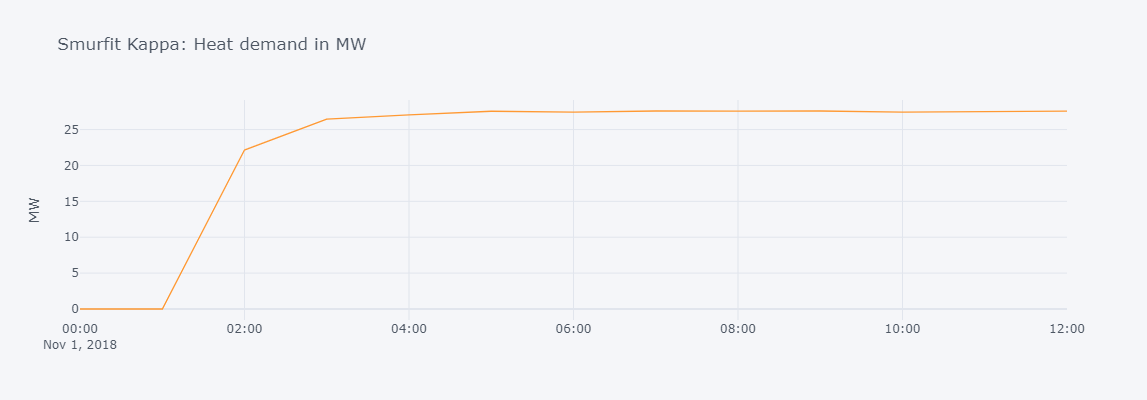

In [ ]:
data['Total demand'] = data['MW (VDG)'] + data['MW (NDG)']
data = data[start:end]
fig_demands_nov2018 = data['Total demand'].resample('1H').mean().iplot(
    title='Smurfit Kappa: Heat demand in MW', 
    yTitle='MW', 
    asFigure=True,
    dimensions=(800, 400)
)
fig_demands_nov2018

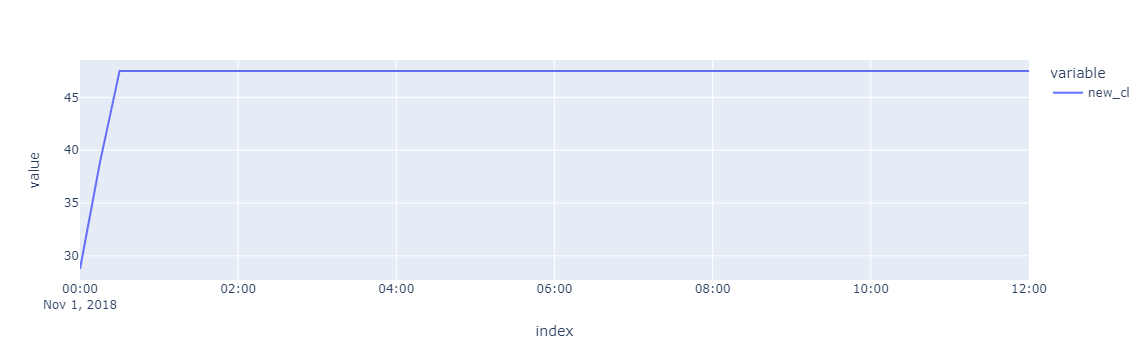

In [ ]:
import plotly.express as px

fig = px.line(df['new_cl'])
fig.show()

In [37]:
def cost_function(th_load, cop, e_price, alt_heat_price, process_demand_MW):
        return (
            th_load / cop * e_price
            + (demand - th_load) * alt_heat_price
        )

In [39]:
max_load = min(heatpump.max_th_power, process_demand_MW)
min_load = heatpump.min_th_power

In [40]:
cost_full_load = cost_function(
    th_load=max_load,
    cop=new_COP,
    e_price = 30,
    alt_heat_price=40,
    process_demand_MW=25
)
cost_full_load

999999150.0